# Part 3/4 - Batch Prediction

## Batch transform job
If you have a file with the samples you want to predict, just upload that file to an S3 bucket and start a Batch Transform job. For this task, you don't need to deploy an endpoint. Sagemaker will create all the resources needed to do this batch prediction, save the results into an S3 bucket and then it will destroy the resources automatically for you

In [1]:
import sagemaker
import numpy as np
import boto3
import os
import pandas as pd
import io
from sklearn import datasets
from sagemaker import get_execution_role

role = get_execution_role()

iris = datasets.load_iris()
prefix='mlops/iris'
sagemaker_session = sagemaker.Session()
bucket = sagemaker_session.default_bucket()
model_name = open('model_name.txt', 'r').read().strip() if os.path.isfile('model_name.txt') else None
if model_name is None:
    raise Exception("You must run Part 1 or 2 before this. There you will train a Model to use here")

In [2]:
batch_dataset_filename="batch_dataset.csv"
np.savetxt(batch_dataset_filename, iris.data, delimiter=",", fmt='%0.3f')
input_batch = sagemaker_session.upload_data(path=batch_dataset_filename, key_prefix='%s/data' % prefix)

In [3]:
%%time

# Initialize the transformer object
transformer=sagemaker.transformer.Transformer(
    base_transform_job_name='mlops-iris',
    model_name=model_name,
    instance_count=1,
    instance_type='ml.c4.xlarge',
    output_path='s3://{}/{}/batch_output'.format(bucket, prefix),
)
# To start a transform job:
transformer.transform(input_batch, content_type='text/csv', split_type='Line')
# Then wait until transform job is completed
transformer.wait()

................................2020-12-14T22:44:56.719:[sagemaker logs]: MaxConcurrentTransforms=4, MaxPayloadInMB=6, BatchStrategy=MULTI_RECORD
[2020-12-14:22:44:54:INFO] No GPUs detected (normal if no gpus installed)
[2020-12-14:22:44:54:INFO] No GPUs detected (normal if no gpus installed)
[2020-12-14:22:44:54:INFO] nginx config: 
worker_processes auto;
daemon off;
pid /tmp/nginx.pid;
error_log  /dev/stderr;

worker_rlimit_nofile 4096;

events {
  worker_connections 2048;
[2020-12-14:22:44:54:INFO] No GPUs detected (normal if no gpus installed)
[2020-12-14:22:44:54:INFO] No GPUs detected (normal if no gpus installed)
[2020-12-14:22:44:54:INFO] nginx config: 
worker_processes auto;
daemon off;
pid /tmp/nginx.pid;
error_log  /dev/stderr;

worker_rlimit_nofile 4096;

events {
  worker_connections 2048;
}

http {
  include /etc/nginx/mime.types;
  default_type application/octet-stream;
  access_log /dev/stdout combined;

  upstream gunicorn {
    server unix:/tmp/gunicorn.sock;
  }

  s

In [4]:
dataset = np.insert(iris.data, 0, iris.target, axis=1)
df = pd.DataFrame(data=dataset, columns=['iris_id'] + iris.feature_names)
df_pred = pd.read_csv(
    io.StringIO(sagemaker_session.read_s3_file(bucket, '{}/batch_output/{}.out'.format(
        prefix, batch_dataset_filename))), names=['predicted_iris_id'] )
df = pd.merge(df,df_pred, left_index=True, right_index=True)
df.head()

,iris_id,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),predicted_iris_id
0,0.0,5.1,3.5,1.4,0.2,0.0
1,0.0,4.9,3.0,1.4,0.2,0.0
2,0.0,4.7,3.2,1.3,0.2,0.0
3,0.0,4.6,3.1,1.5,0.2,0.0
4,0.0,5.0,3.6,1.4,0.2,0.0


In [5]:
from sklearn.metrics import f1_score
score = f1_score(df['iris_id'], df['predicted_iris_id'],labels=[0.0,1.0,2.0],average='micro')

print('F1 Score(micro): %.1f' % (score * 100.0))

F1 Score(micro): 97.3


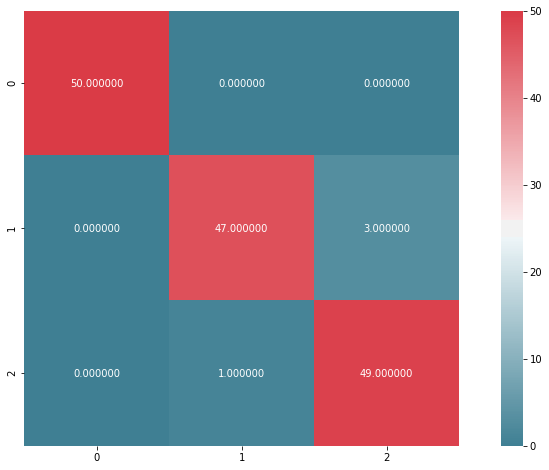

In [6]:
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix
cnf_matrix = confusion_matrix(df['iris_id'], df['predicted_iris_id'])

f, ax = plt.subplots(figsize=(15, 8))
sns.heatmap(cnf_matrix, annot=True, fmt="f", mask=np.zeros_like(cnf_matrix, dtype=np.bool), 
            cmap=sns.diverging_palette(220, 10, as_cmap=True),
            square=True, ax=ax)

## Alright, now that you know how to run a batch prediction ...

Click [here to start the Part 4/4](04_BasicModel_Part4_ModelMonitoring.ipynb) of this warmup: Model Monitoring

# The end